# Informe Técnico - Exploración Tabla Usuarios

## 1. Descripción general
- Cantidad de registros: 1000
- Columnas presentes: 7

## 2. Revisión de columnas
| Columna       | Tipo de dato | Valores no nulos | Observaciones                         |
| -----------   | ------------ | ---------------- | --------------------------------------|
| UsuarioID     | int64        | 1000             | Clave primaria.                       |
| Nombre        | object       | 1000             | Texto. No hay valores faltantes.      |
| Apellido      | object       | 1000             | Texto.                                |
| email         | object       | 1000             | texto.                                |
| Contraseña    | object       | 1000             | Unidades disponibles.                 |
| FechaRegistro | datetime     | 1000             | Fecha registro de usuario, default now|

## 3. Calidad de datos
- Valores faltantes: No hay
- Valores por defecto: Fecha de registro, fecha HOY.

## 4. Principales hallazgos
- Alta tasa de conversión (usuarios que realizaron órdenes)
- Usuarios con mayor gasto acumulado es elevado y tomando en cuenta valor promedio de ordenes, sugiere muchas compras y no compras voluminosas.
- - El valor máximo observado en una orden individual es de $999,99.

- - El gasto acumulado de los usuarios top (~$30.000) indica que han realizado al menos entre 30 y 60 órdenes, si consideramos los valores promedio y máximo del total en ordenes.

- - Esto sugiere una alta recurrencia de compra entre los usuarios top
- Todos los usuarios han realizado al menos una orden.
- Todos los usuarios han dejado al menos una reseña.

## 5. Visualizaciones
- Se incluye gráfico de barras con los 10 usuarios que más han gastado.


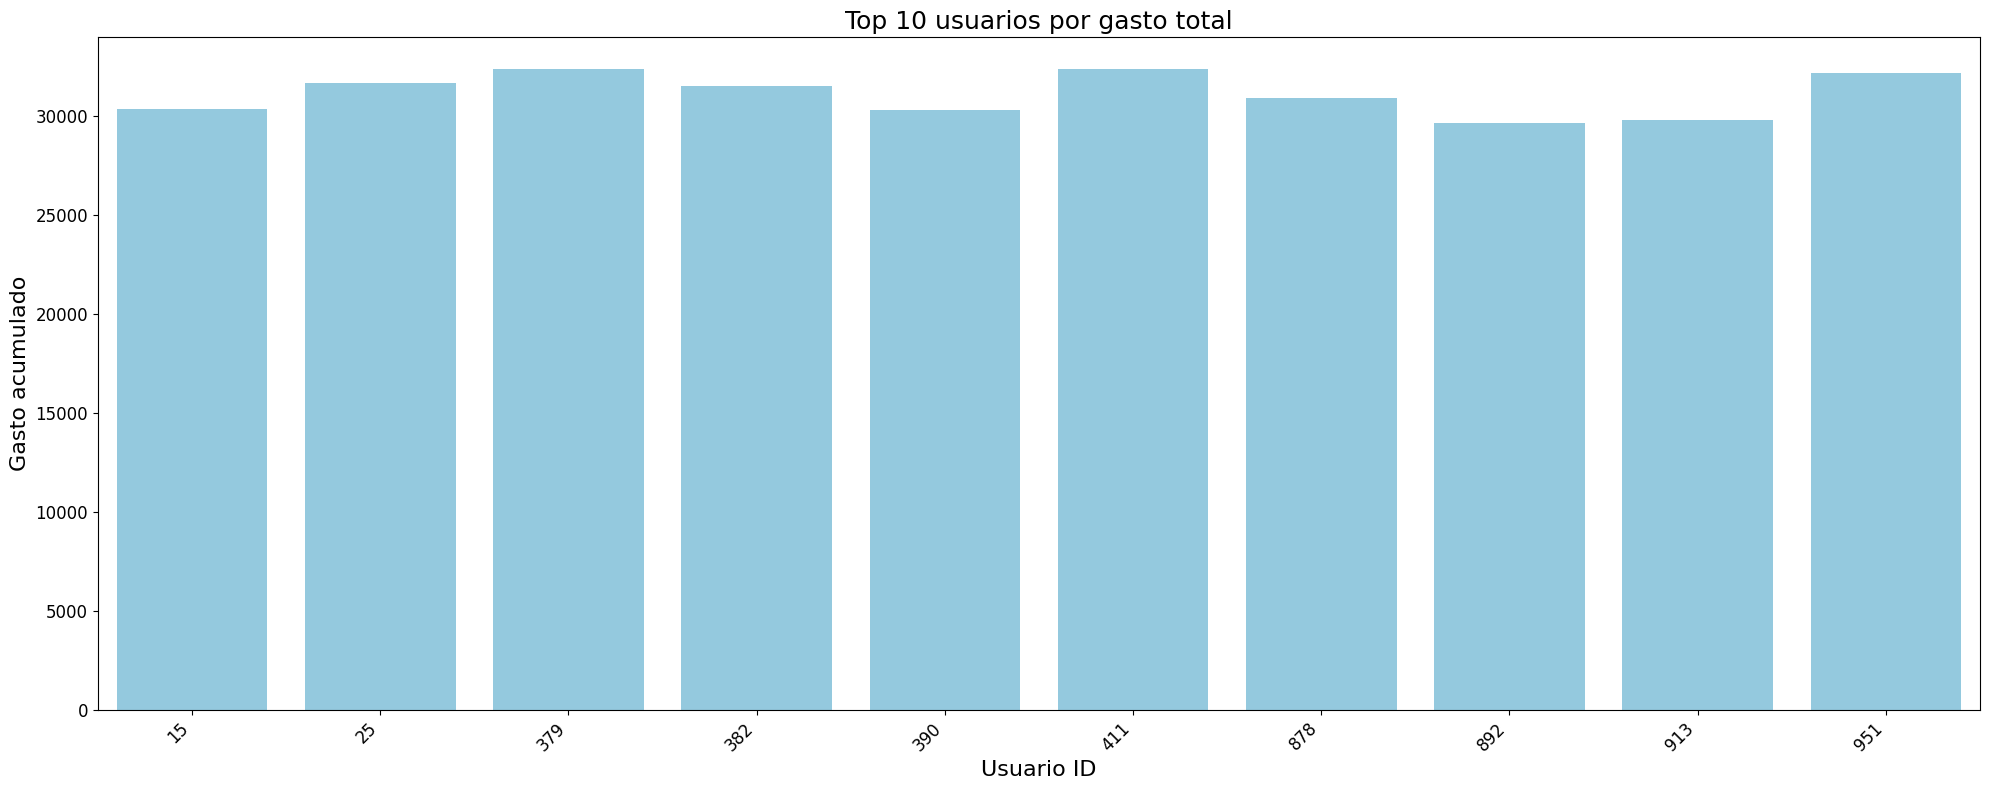

In [2]:
from app.utils import plot_utils,postgres_utils


query = """
SELECT "UsuarioID", SUM("Total") AS "GastoTotal"
FROM "Ordenes"
GROUP BY "UsuarioID"
ORDER BY "GastoTotal" DESC
LIMIT 10
"""

top_gastadores_df = postgres_utils.run_query(query)

plot_utils.plot_top_bar_chart(
    df=top_gastadores_df,
    x_column='UsuarioID',
    y_column='GastoTotal',
    plot_title="Top 10 usuarios por gasto total",
    x_label="Usuario ID",
    y_label="Gasto acumulado",
    top_n=10,
    figsize=(20, 8)
)


## 6. Decisiones tomadas
- Descartar columna `fecha_registro` del análisis temporal
- Posible estandarización de nombres a futuro
- Hashear columna contraseña por seguridad.

## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)

# Informe Técnico - Exploración Tabla Productos

## 1. Descripción general
- Cantidad de registros: 36
- Columnas presentes: 6

## 2. Revisión de columnas
| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| ProductoID  | int64        | 36               | Clave primaria.                    |
| Nombre      | object       | 36               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 36               | Texto. Puede contener redundancia. |
| Precio      | float64      | 36               | Valor numérico.                    |
| Stock       | int64        | 36               | Unidades disponibles.              |
| CategoriaID | int64        | 36               | Clave foránea a `Categorias`.      |

## 3. Calidad de datos
- Valores faltantes: -
- Valores por defecto: -
- Validaciones aplicadas: Stock, Precio y Nombre no pueden ser nulos.

## 4. Principales hallazgos
- Alta dispersión en precio de productos, son pocos items (en relación al número de órdenes (10000) y de compradores (1000) con precios que oscilan entre 20 y 799).
- Si bien la variabilidad en precios puede ser habitual, debería tomarse en cuenta para el análisis de venta la presencia de los items de mayor valor.
- En los diez productos de mayor valor se encuentra el máximo de 799 y el último de 299.
- Se detectó que el campo Nombre no es único, lo cual podría generar confusión en procesos de visualización, búsqueda o reportes. Se sugiere revisar con el área de negocio si se espera que cada producto tenga un nombre distintivo. En caso afirmativo, podría establecerse una restricción UNIQUE sobre dicho campo o trabajar con identificadores más robustos en las consultas.
- Se detectaron productos con nula rotación como Cuaderno universitario, Camiseta de hombre, Alcohol en gel, tienen el mayor stock y cero ventas.

In [3]:
from app.utils import notebook_utils, postgres_utils

query = """
SELECT 
    p."ProductoID",
    p."Nombre",
    p."Stock",
    COALESCE(SUM(d."Cantidad"), 0) AS total_vendido
FROM "Productos" p
LEFT JOIN "DetalleOrdenes" d ON p."ProductoID" = d."ProductoID"
GROUP BY p."ProductoID", p."Nombre", p."Stock"
HAVING COALESCE(SUM(d."Cantidad"), 0) < 100
ORDER BY p."Stock" DESC
LIMIT 10;
"""
notebook_utils.print_colored("Productos con alto stock y bajas ventas (< 500)", "green")
postgres_utils.run_query(query)


,ProductoID,Nombre,Stock,total_vendido
0,59,Cuaderno Universitario 100h,300,0
1,95,Cuaderno Universitario 100h,300,0
2,99,Alcohol en Gel 500ml,200,0
3,40,Camiseta Básica Hombre,200,0
4,63,Alcohol en Gel 500ml,200,0
5,76,Camiseta Básica Hombre,200,0
6,60,Set de Lápices de Colores,150,0
7,96,Set de Lápices de Colores,150,0
8,41,Jeans Skinny Mujer,150,0
9,85,Crema Hidratante Facial,150,0


## 5. Visualizaciones

* Se observan 15 outliers de precio por encima de 120, con uno de ellos alcanzando los 799. Esto contrasta con el resto de los productos cuyo precio ronda los 30.
* Se observan 9 outliers de stock entre 200 y 300.

Number of outliers in 'Precio': 15


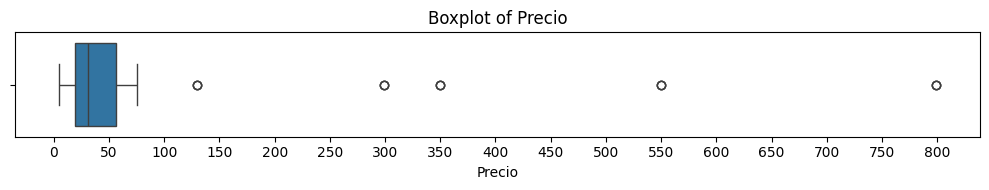

Number of outliers in 'Stock': 9


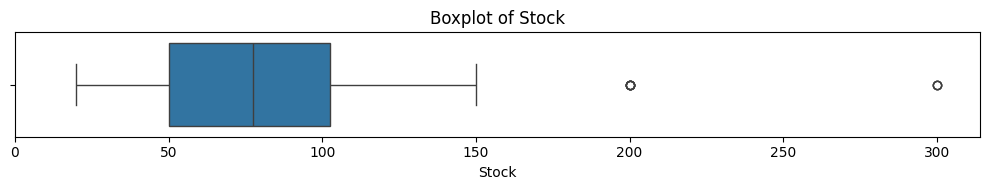

In [4]:
from app.utils import plot_utils

outliers_precio, lower_precio, upper_precio = plot_utils.plot_boxplot_with_outliers('Productos', 'Precio', step=50)

outliers_stock, lower_stock, upper_stock = plot_utils.plot_boxplot_with_outliers('Productos', 'Stock', step=50)

* Existen productos con altos niveles de stock pero sin ninguna venta registrada. El top 5 incluye Cuaderno Universitario 100h, Camiseta Básica Hombre, etc.

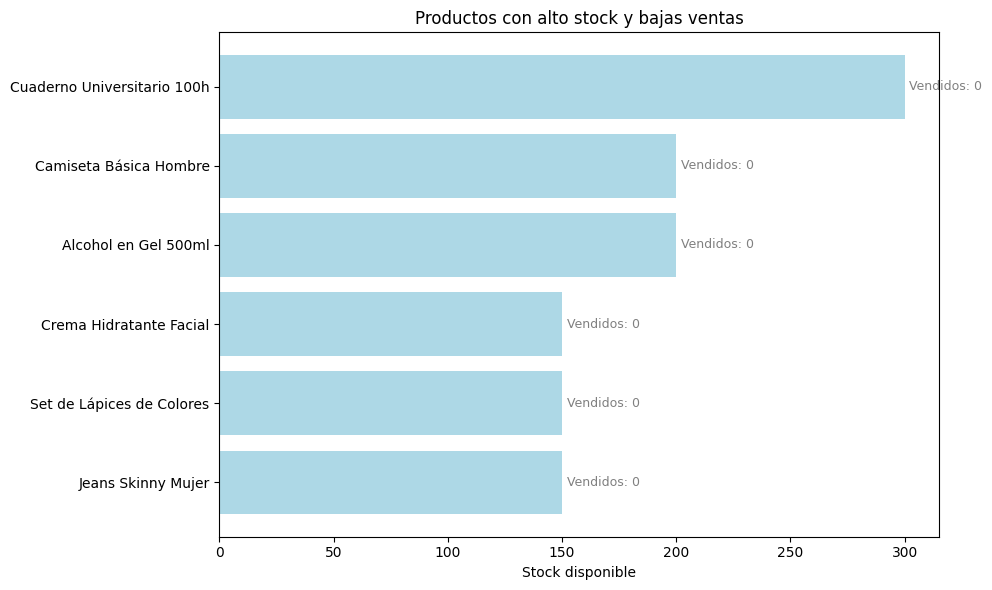

In [1]:
from app.utils import plot_utils

plot_utils.plot_high_stock_lowest_sells()



## 6. Decisiones tomadas
- Evaluar la necesidad de hacer único el campo Nombre, según el uso por parte del negocio.
- Crear índice sobre Stock o Precio, dada su alta frecuencia de uso en consultas analíticas.
- Definir vistas para consultas recurrentes (por ejemplo, productos con baja rotación).
  
## 7. Consultas SQL relevantes
[Anexo](./scripts/sql/report.sql)

# Informe Técnico - Exploración Tabla Categorías

## 1. Descripción general
- Cantidad de registros: 12
- Columnas presentes: 3

## 2. Revisión de columnas
| Columna     | Tipo de dato | Valores no nulos | Observaciones                      |
| ----------- | ------------ | ---------------- | ---------------------------------- |
| CategoriaID | int64        | 12               | Clave primaria.                    |
| Nombre      | object       | 12               | Texto. No hay valores faltantes.   |
| Descripcion | object       | 12               | Texto. Puede contener redundancia. |


## 3. Calidad de datos
- Valores faltantes: -
- Valores por defecto: -
- Validaciones aplicadas: -

## 4. Principales hallazgos
- El campo nombre no es único y es de texo libre al igual que la descripción. Aunque el campo Nombre no es clave primaria, desde una perspectiva de negocio podría esperarse que sea único. Por ejemplo, tener dos categorías llamadas "Electrónica" pero con distintos CategoriaID puede resultar confuso en reportes, búsquedas o visualización en interfaces.


## 6. Recomendaciones
- Evaluar la posibilidad de agregar una restricción de unicidad: 
```sql
ALTER TABLE "Categorias" ADD CONSTRAINT unique_categoria_nombre UNIQUE ("Nombre");
```
- Limpieza/ normalización de textos :
Ejemplos:
| Original                | Propuesta normalizada   |
| ----------------------- | ----------------------- |
| " electrónica  "        | "Electrónica"           |
| "Belleza Y cuidado"     | "Belleza y Cuidado"     |
| "DEPORTES Y aire libre" | "Deportes y Aire Libre" |

No se propone análisis exploratorio adicional sobre esta tabla, ya que su principal función es referencial y ya ha sido utilizada en las agregaciones de ventas por categoría. Se recomienda únicamente asegurar su consistencia y unicidad.

# Informe Técnico - Exploración Tabla Usuarios

## 1. Descripción general
- Cantidad de registros: ...
- Columnas presentes: ...

## 2. Revisión de columnas
| Columna | Tipo | Descripción | Observaciones |
|--------|------|-------------|----------------|

## 3. Calidad de datos
- Valores faltantes: ...
- Valores por defecto: ...
- Validaciones aplicadas: ...

## 4. Principales hallazgos
- Alta tasa de conversión (usuarios que realizaron órdenes)
- Usuarios con mayor gasto acumulado
- Posibles problemas con duplicados en emails

## 5. Visualizaciones
(incluir gráficos exportados del EDA)

## 6. Decisiones tomadas
- Descartar columna `fecha_registro` del análisis temporal
- Posible estandarización de nombres a futuro
- Validar unicidad de `Email`

## 7. Consultas SQL relevantes
(incluir como anexo)

# Informe Técnico - Exploración Tabla Usuarios

## 1. Descripción general
- Cantidad de registros: ...
- Columnas presentes: ...

## 2. Revisión de columnas
| Columna | Tipo | Descripción | Observaciones |
|--------|------|-------------|----------------|

## 3. Calidad de datos
- Valores faltantes: ...
- Valores por defecto: ...
- Validaciones aplicadas: ...

## 4. Principales hallazgos
- Alta tasa de conversión (usuarios que realizaron órdenes)
- Usuarios con mayor gasto acumulado
- Posibles problemas con duplicados en emails

## 5. Visualizaciones
(incluir gráficos exportados del EDA)

## 6. Decisiones tomadas
- Descartar columna `fecha_registro` del análisis temporal
- Posible estandarización de nombres a futuro
- Validar unicidad de `Email`

## 7. Consultas SQL relevantes
(incluir como anexo)